In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import *
from scipy import signal
import math
sns.set_style("whitegrid")
from numpy.fft import fft, fftshift

In [2]:
users_exp = pd.read_pickle("../Exercicio2/users.dat")
user1_1, user1_2, user2_1, user2_2, user3_1, user3_2, user4_1, user4_2 = users_exp

In [3]:
def ufrag(user, xi, xf):
    return user[ (xi<=user['Time (min)']) & (user['Time (min)'] < xf) ].reset_index().drop("index", axis = 1)

In [4]:
def plot_walk(subplots, user, c):
    xmean = user['X'].mean()
    xstd = user['X'].std()
    subplots[0].plot( user['Time (min)'], user['X'], c )
    subplots[0].plot( user['Time (min)'], np.full( (len(user['X']), ), xmean ), 'k:')
    subplots[0].plot( user['Time (min)'], np.full( (len(user['X']), ), xmean + 3*xstd ), 'r--' )
    subplots[0].plot( user['Time (min)'], np.full( (len(user['X']), ), xmean - 3*xstd ), 'r--' )
    subplots[0].set_xlabel("Time (min)")
    subplots[0].set_ylabel("ACC_X")
    
    
    ymean = user['Y'].mean()
    ystd = user['Y'].std()
    subplots[1].plot( user['Time (min)'], user['Y'], c )
    subplots[1].plot( user['Time (min)'], np.full( (len(user['X']), ), ymean ), 'k:')
    subplots[1].plot( user['Time (min)'], np.full( (len(user['X']), ), ymean + 3*ystd ), 'r--' )
    subplots[1].plot( user['Time (min)'], np.full( (len(user['X']), ), ymean - 3*ystd ), 'r--' )
    subplots[1].set_xlabel("Time (min)")
    subplots[1].set_ylabel("ACC_Y")
    
    zmean = user['Z'].mean()
    zstd = user['Z'].std()
    subplots[2].plot( user['Time (min)'], user['Z'], c )
    subplots[2].plot( user['Time (min)'], np.full( (len(user['X']), ), zmean ), 'k:')
    subplots[2].plot( user['Time (min)'], np.full( (len(user['X']), ), zmean + 3*zstd ), 'r--' )
    subplots[2].plot( user['Time (min)'], np.full( (len(user['X']), ), zmean - 3*zstd ), 'r--' )
    subplots[2].set_xlabel("Time (min)")
    subplots[2].set_ylabel("ACC_Z")

In [5]:
def plot_user_walks(user_walks):
    figure, subplots = plt.subplots(nrows = 6, ncols= 2, figsize = (14,10))
    colors = ['royalblue', 'maroon', 'darkorange', 'olive']
    
    for i in range(len(user_walks)):
        if i < 2:
            plot_walk(subplots[:3,i], user_walks[i], colors[i] )
            subplots[0,i].set_title(f"WALK {i+1}")
        else:
            plot_walk(subplots[3:,i-2], user_walks[i], colors[i] )
            subplots[3,i-2].set_title(f"WALK {i+1}")
    figure.tight_layout()

In [6]:
def set_between_std(user):
    xmean = user['X'].mean()
    xstd = user['X'].std()
    user['X'] = user['X'].map(lambda x: (xmean + 2.5*xstd) if (x > xmean + 3*xstd) 
                              else ( (xmean - 2.5*xstd) if (x < xmean - 3*xstd) 
                                    else x ) )
    
    ymean = user['Y'].mean()
    ystd = user['Y'].std()
    user['Y'] = user['Y'].map(lambda x: (ymean + 2.5*ystd) if (x > ymean + 3*ystd) 
                              else ( (ymean - 2.5*ystd) if (x < ymean - 3*ystd) 
                                    else x ) )
    
    zmean = user['Z'].mean()
    zstd = user['Z'].std()
    user['Z'] = user['Z'].map(lambda x: (zmean + 2.5*zstd) if (x > zmean + 3*zstd) 
                              else ( (zmean - 2.5*zstd) if (x < zmean - 3*zstd) 
                                    else x ) )

## Fragmentação da atividade dinâmica WALKING
### Primeiro Seccionar os intervalos da realização da atividade, de modo a poder operar apenas sobre eles

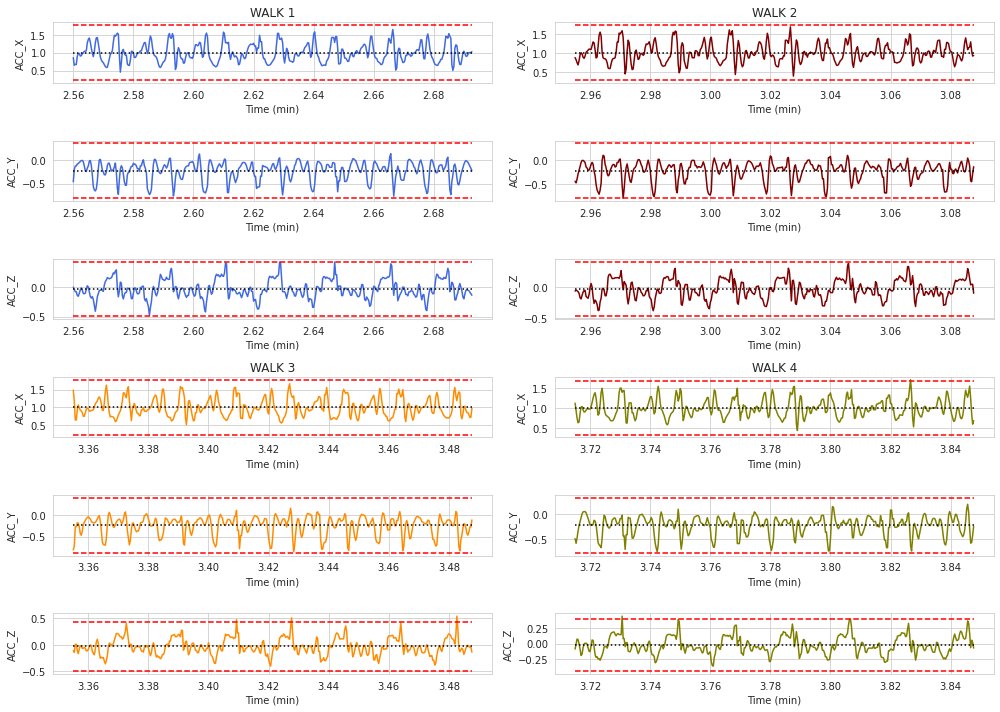

In [7]:
unow = user1_1
walks_user1_1 = [ ufrag(unow, 2.56, 2.693), ufrag(unow, 2.955, 3.088), ufrag(user1_1, 3.355, 3.488), ufrag(user1_1, 3.715, 3.848) ]
plot_user_walks(walks_user1_1)

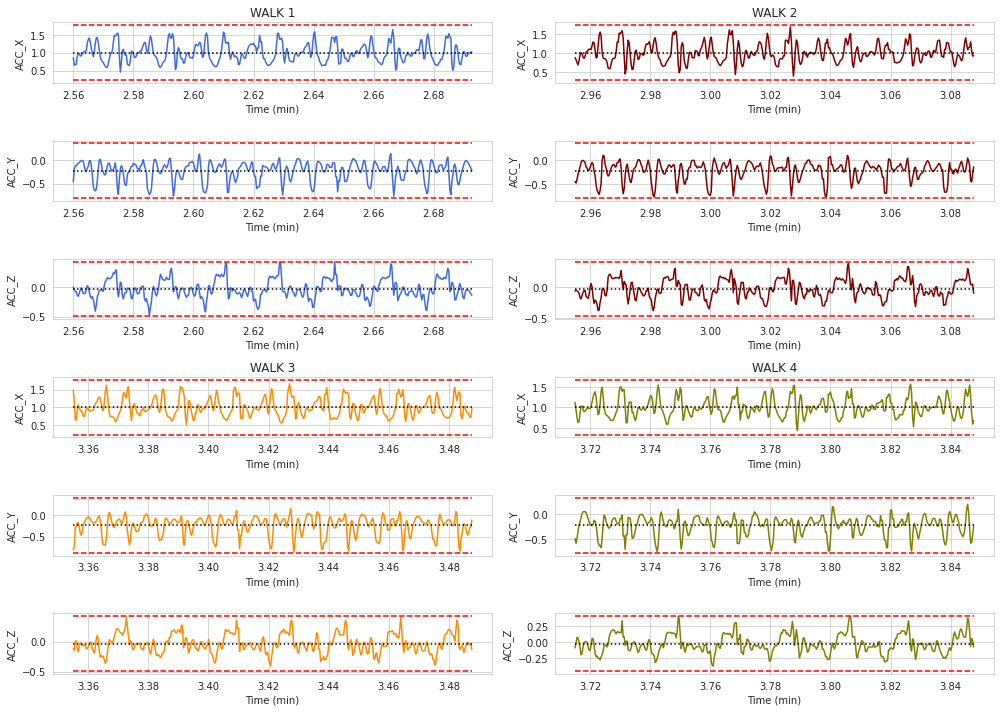

In [8]:
for i in range(len(walks_user1_1)):
    set_between_std(walks_user1_1[i])
plot_user_walks(walks_user1_1)

In [9]:
def detrend_user_walk(user):
    new = user.copy()
    new['X'] = signal.detrend(user['X'])
    new['Y'] = signal.detrend(user['Y'])
    new['Z'] = signal.detrend(user['Z'])
    return new

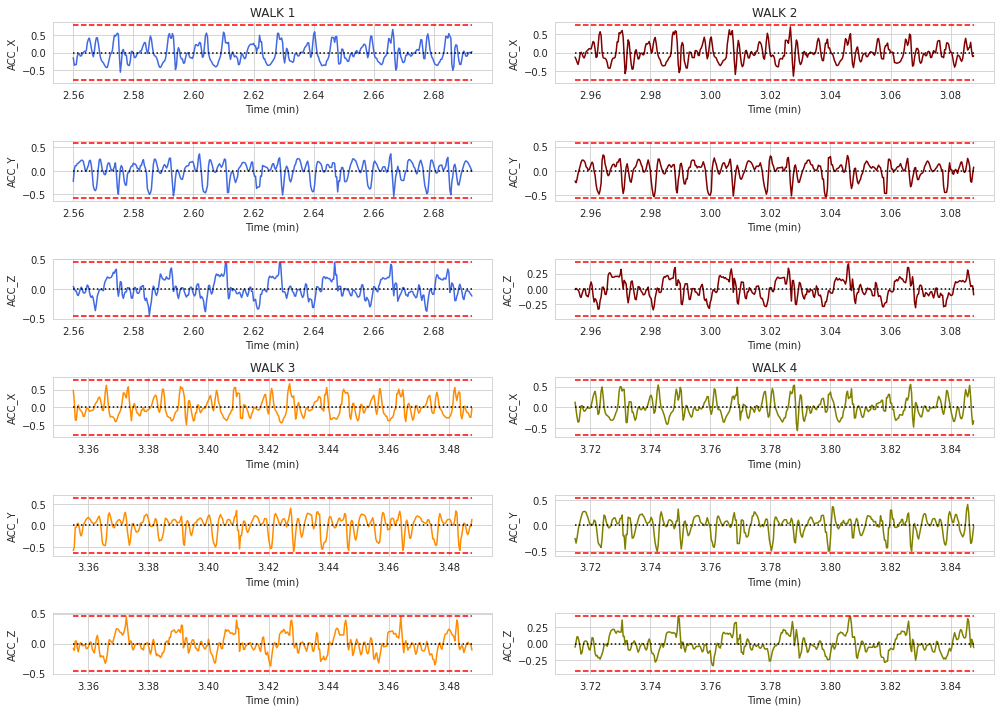

In [10]:
walks_user1_1_detrended = []
for i in walks_user1_1:
    walks_user1_1_detrended.append( detrend_user_walk(i) )
plot_user_walks(walks_user1_1_detrended)

In [11]:
walks_user1_1_detrended[0].count()

X             399
Y             399
Z             399
Time (min)    399
dtype: int64

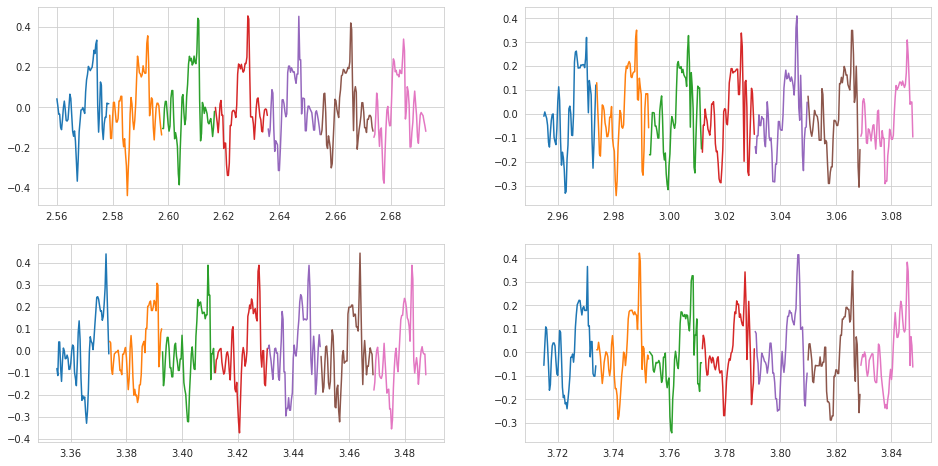

In [12]:
step = 57
plt.figure(figsize = (16,8))
plt.subplot(221)
for i in range(1,399//step + 1):
    plt.plot(walks_user1_1_detrended[0]['Time (min)'][(i-1)*step: i * step], walks_user1_1_detrended[0]['Z'][(i-1)*step: i * step])
    
plt.subplot(222)
for i in range(1,399//step + 1):
    plt.plot(walks_user1_1_detrended[1]['Time (min)'][(i-1)*step: i * step], walks_user1_1_detrended[1]['Z'][(i-1)*step: i * step])
    
plt.subplot(223)
for i in range(1,399//step + 1):
    plt.plot(walks_user1_1_detrended[2]['Time (min)'][(i-1)*step: i * step], walks_user1_1_detrended[2]['Z'][(i-1)*step: i * step])
    
plt.subplot(224)
for i in range(1,399//step + 1):
    plt.plot(walks_user1_1_detrended[3]['Time (min)'][(i-1)*step: i * step], walks_user1_1_detrended[3]['Z'][(i-1)*step: i * step])

In [13]:
periods = list(map(lambda x: np.array(x['Z'])[:step], walks_user1_1_detrended) )
for i in range(1,399//step):
    for j in range(4):
        periods[j] += np.array(walks_user1_1_detrended[j]['Z'])[i*step:(i+1)*step]
periods = list(map(lambda x: x/(399//step + 1), periods))

In [14]:
steps = list(filter(lambda x: 399%x==0, range(1, 399//2+1)))
print(steps, len(steps))

[1, 3, 7, 19, 21, 57, 133] 7


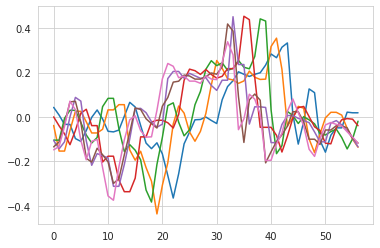

In [15]:
step = steps[5]
for i in range(399//step):
    values = np.array(walks_user1_1_detrended[0]['Z'])[i*step:(i+1)*step]
    plt.plot(range(len(values)), values )

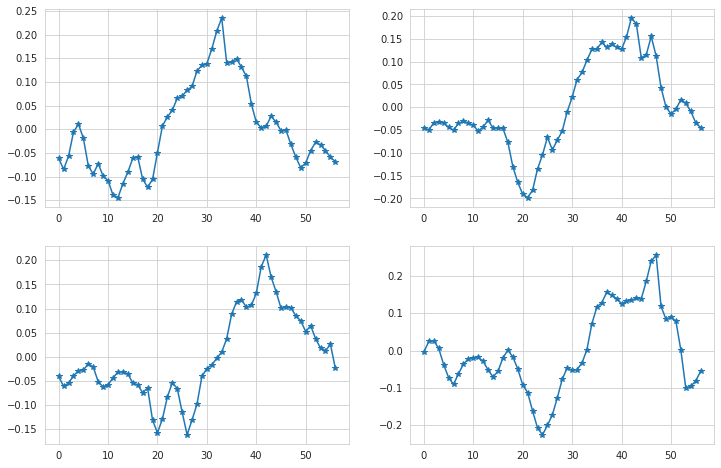

In [16]:
plt.figure(figsize = (12,8))
plt.subplot(221)
plt.plot(range(step), periods[0], '-*')

plt.subplot(222)
plt.plot(range(step), periods[1], '-*')

plt.subplot(223)
plt.plot(range(step), periods[2], '-*')

plt.subplot(224)
plt.plot(range(step), periods[3], '-*')

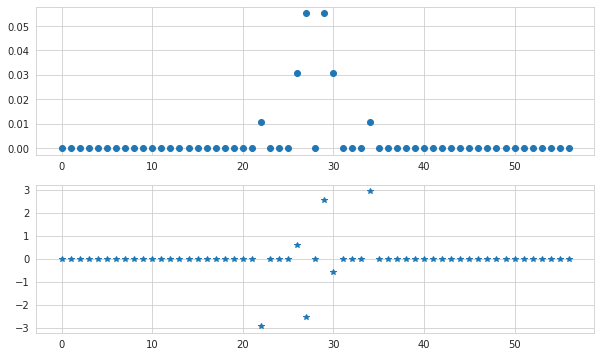

In [17]:
dft_values = fftshift(fft(periods[0]))
dft_values[ np.abs(dft_values/step) < 0.01 ] = 0
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot( range(len(dft_values) ), np.abs(dft_values)/step,'o' )
plt.subplot(212)
plt.plot( range(len(dft_values) ), np.unwrap(np.angle(dft_values/step)),'*')

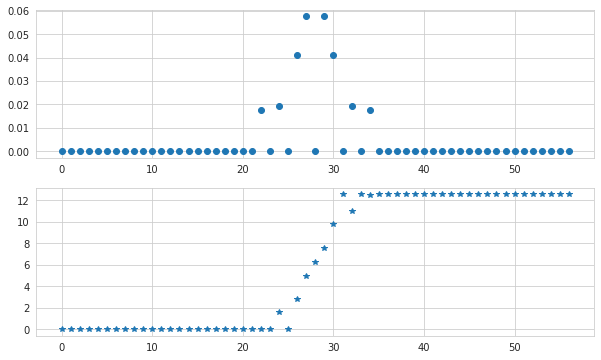

In [18]:
dft_values = fftshift(fft(periods[3]))
dft_values[ np.abs(dft_values/step) < 0.01 ] = 0
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot( range(len(dft_values) ), np.abs(dft_values)/step,'o' )
plt.subplot(212)
plt.plot( range(len(dft_values) ), np.unwrap(np.angle(dft_values/step)),'*')

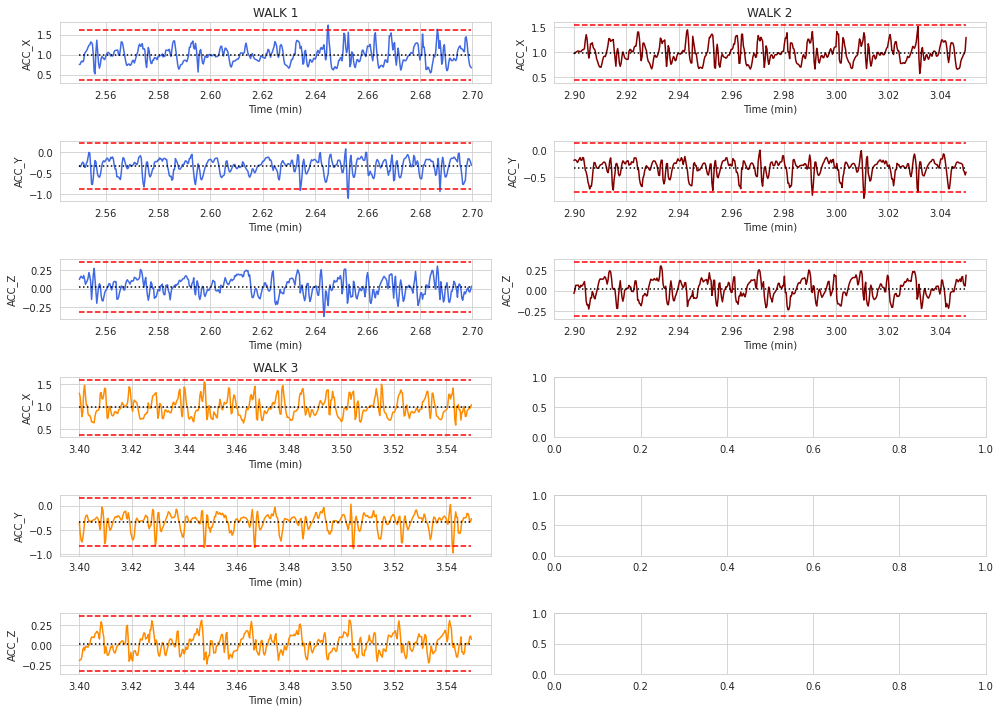

In [19]:
unow = user2_1
size = 0.15
walks_user2_1 = [ ufrag(unow, 2.55, 2.55+size), ufrag(unow, 2.9, 2.9 + size), ufrag(unow, 3.4, 3.4+size) ]
plot_user_walks(walks_user2_1)

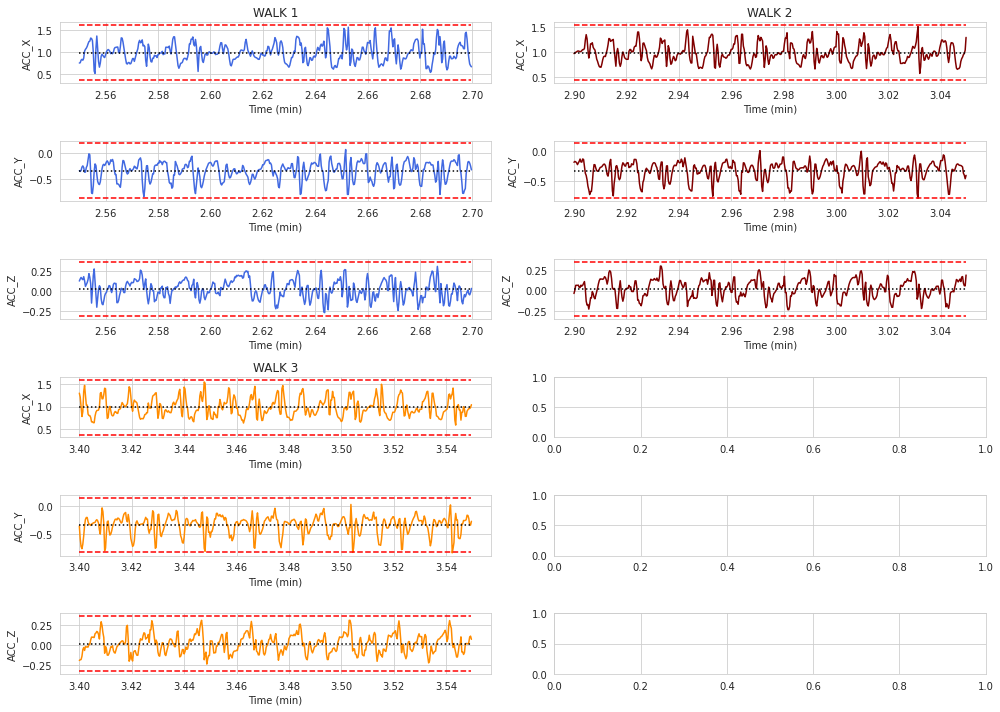

In [20]:
for i in range(len(walks_user2_1)):
    set_between_std(walks_user2_1[i])
plot_user_walks(walks_user2_1)

In [21]:
walks_user2_1_detrended = []
for i in walks_user2_1:
    walks_user2_1_detrended.append( detrend_user_walk(i) )